# Predicción de la demanda

En este módulo, se ha desarrollado un modelo de predicción basado en series de tiempo utilizando un conjunto de datos históricos de ventas. El enfoque en series de tiempo permite capturar patrones temporales, como tendencias estacionales y fluctuaciones semanales, que son comunes en el sector minorista.

### **Objetivo**

Estimar la demanda de los próximos 30 días para cada tienda en función de diversas variables externas (como eventos promocionales, días festivos y condiciones económicas) y características propias de cada establecimiento (como tamaño y tipo de la tienda ). Estas predicciones permiten a los gerentes de ventas y operaciones tomar decisiones informadas sobre compras, promociones y estrategias de precios, optimizando así la cadena de suministro y mejorando la rentabilidad del negocio

# Librerías

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow import keras
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError

# Preprocesamiento y Exploración de los datasets

Se han utilizado tres datasets principales, los cuales fueron integrados para la construcción del modelo. Estos datos provienen de Walmart y están disponibles en la plataforma Kaggle ([Ahmedov, 2023](https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast/data)).

### Dataset de caracteristicas: features.csv

In [9]:
features_df = pd.read_csv('../dataset/features.csv')

# Mostrar las primeras filas del dataset
print(features_df.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  


In [8]:
print(features_df.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


Columnas del dataset

* Store: Número de la tienda a la que pertenecen los datos.
* Date: Fecha en la que se registraron los datos.
* Temperature: Temperatura promedio en la región de la tienda (en grados Fahrenheit).
* Fuel_Price: Precio del combustible en la región de la tienda.
* MarkDown1 - MarkDown5: Descuentos promocionales aplicados a lo largo del tiempo. Pueden ser valores NaN si no hubo descuentos en ese período. 
* CPI (Consumer Price Index): Índice de Precios al Consumidor, que mide la inflación en la región de la tienda.
* Unemployment: Tasa de desempleo en la región de la tienda.
* IsHoliday: Indica si la fecha corresponde a un día festivo (True) o no (False).

Este dataset proporciona información sobre factores externos que pueden influir en las ventas, como la temperatura, los precios del combustible, la inflación y la tasa de desempleo.

In [9]:
# Variables y sus tipos
print(features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None


In [10]:
# Estadisticas de las variables
print(features_df.describe())

             Store  Temperature   Fuel_Price      MarkDown1      MarkDown2  \
count  8190.000000  8190.000000  8190.000000    4032.000000    2921.000000   
mean     23.000000    59.356198     3.405992    7032.371786    3384.176594   
std      12.987966    18.678607     0.431337    9262.747448    8793.583016   
min       1.000000    -7.290000     2.472000   -2781.450000    -265.760000   
25%      12.000000    45.902500     3.041000    1577.532500      68.880000   
50%      23.000000    60.710000     3.513000    4743.580000     364.570000   
75%      34.000000    73.880000     3.743000    8923.310000    2153.350000   
max      45.000000   101.950000     4.468000  103184.980000  104519.540000   

           MarkDown3     MarkDown4      MarkDown5          CPI  Unemployment  
count    3613.000000   3464.000000    4050.000000  7605.000000   7605.000000  
mean     1760.100180   3292.935886    4132.216422   172.460809      7.826821  
std     11276.462208   6792.329861   13086.690278    39.7383

In [3]:
# Ver valores nulos
print(features_df.isnull().sum())

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


In [14]:
# Número de filas antes de eliminar
num_rows_before = features_df.shape[0]

# Eliminar filas con datos NaN
features_df_cleaned = features_df.dropna()

# Número de filas después de eliminar
num_rows_after = features_df_cleaned.shape[0]

# Mostrar la cantidad de filas antes y después
print(f"Número de filas antes de eliminar: {num_rows_before}")
print(f"Número de filas después de eliminar: {num_rows_after}")

Número de filas antes de eliminar: 8190
Número de filas después de eliminar: 2069


In [5]:
print(features_df_cleaned.head())

    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
92      1  2011-11-11        59.11       3.297   10382.90    6115.67   
93      1  2011-11-18        62.25       3.308    6074.12     254.39   
94      1  2011-11-25        60.14       3.236     410.31      98.00   
95      1  2011-12-02        48.91       3.172    5629.51      68.00   
96      1  2011-12-09        43.93       3.158    4640.65      19.00   

    MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
92     215.07    2406.62    6551.42  217.998085         7.866      False  
93      51.98     427.39    5988.57  218.220509         7.866      False  
94   55805.51       8.00     554.92  218.467621         7.866       True  
95    1398.11    2084.64   20475.32  218.714733         7.866      False  
96     105.02    3639.42   14461.82  218.961846         7.866      False  


Observamos la distribución que tienen las varibales númericas

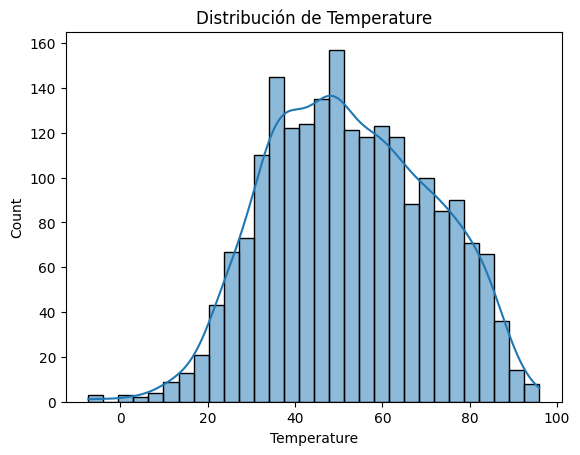

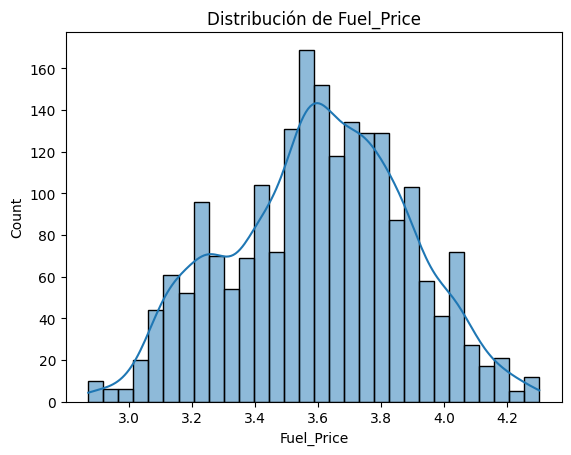

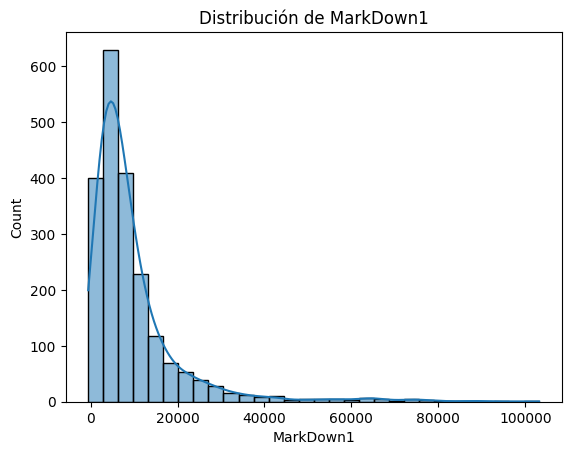

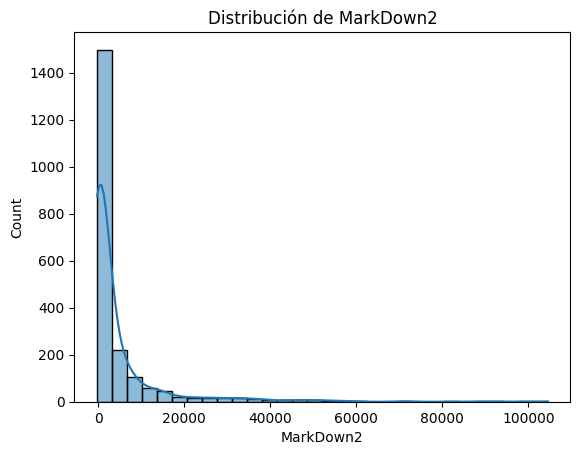

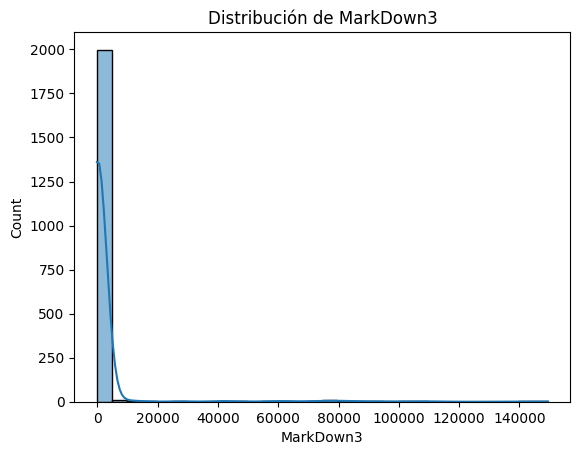

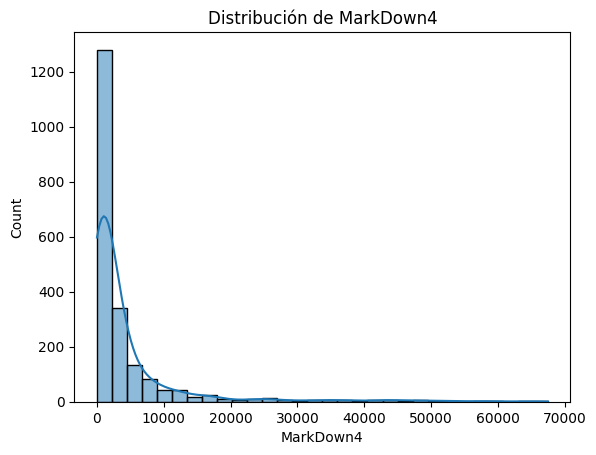

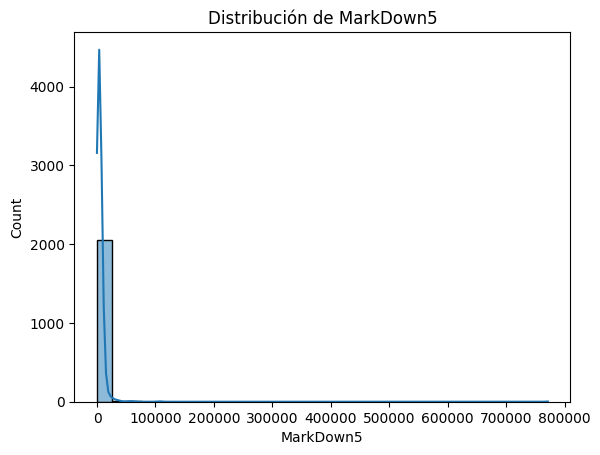

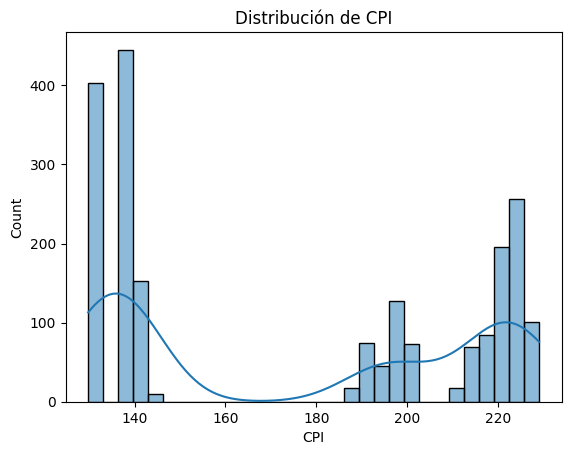

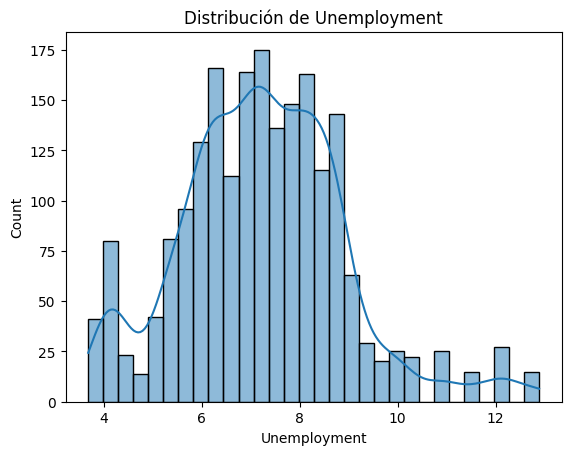

In [14]:
for i in features_df_cleaned.columns:
    # Histograma de una variable, por ejemplo, Temperature
    if (i=="Store" or i=="Date" or i=="IsHoliday"):
        continue
    sns.histplot(features_df_cleaned[i], bins=30, kde=True)
    plt.title(f"Distribución de {i}")
    plt.show()

### Análisis de las distribuciones mostradas en las gráficas:

Temperature:

* La distribución es aproximadamente normal con una ligera asimetría a la derecha.
* La mayoría de los valores se concentran alrededor de 40 a 60 grados, lo que indica una tendencia hacia temperaturas moderadas.
* Hay pocos valores extremos en ambos lados, lo que sugiere poca variabilidad extrema en la temperatura.

Fuel_Price:

* La distribución también es aproximadamente normal, con un pico alrededor de 3.6.
* La asimetría es mínima, aunque se observa una ligera cola hacia la derecha.
* Esto sugiere que la mayoría de los precios del combustible están en un rango moderado, con algunos casos de precios más altos.

MarkDown1-5:

* La distribución es altamente sesgada a la derecha.
* La mayoría de los valores se agrupan cerca de cero, con pocos valores extremadamente altos.
* Esto sugiere que la mayoría de los descuentos son pequeños, con algunos eventos de descuentos muy altos pero poco frecuentes.

CPI (Índice de Precios al Consumidor):

* La distribución muestra una forma bimodal, con dos picos significativos en torno a 140 y 220.
* Esto podría indicar la presencia de dos grupos o periodos económicos distintos en los datos.
* La caída pronunciada entre los picos sugiere una ausencia de valores intermedios, posiblemente debido a cambios en la economía o metodología de cálculo.

Unemployment:

* La distribución es aproximadamente normal pero con asimetría a la derecha.
* La mayoría de los valores se encuentran entre 6 y 8, lo que indica una tasa de desempleo moderada en general.
* Existen valores más altos en la cola derecha, sugiriendo algunos periodos o regiones con desempleo más elevado.

### Dataset de tiendas: store.csv

In [10]:
stores_df = pd.read_csv('../dataset/stores.csv')

# Mostrar las primeras filas del dataset
print(stores_df.head())

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


In [16]:
print(stores_df.columns)

Index(['Store', 'Type', 'Size'], dtype='object')


In [17]:
stores_df.shape

(45, 3)

In [18]:
# Variables y sus tipos
print(stores_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


In [19]:
#Ver valores nulos
print(stores_df.isnull().sum())

Store    0
Type     0
Size     0
dtype: int64


In [20]:
# Estadisticas de las variables
print(stores_df.describe())

           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000


Distribución de variables:

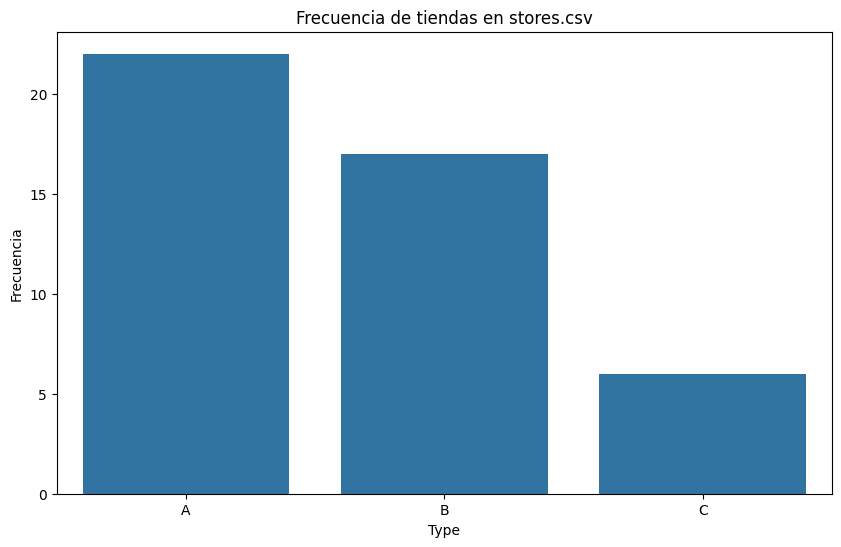

In [21]:
def plot_bar_chart_seaborn(df, column, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

# Llamar a la función para graficar
plot_bar_chart_seaborn(stores_df, 'Type', 'Frecuencia de tiendas en stores.csv')

Frecuencia de tiendas en stores.csv: Muestra la cantidad de tiendas por tipo (A, B y C). Se observa que el tipo A es el más común, seguido del B y finalmente el C con una menor frecuencia.


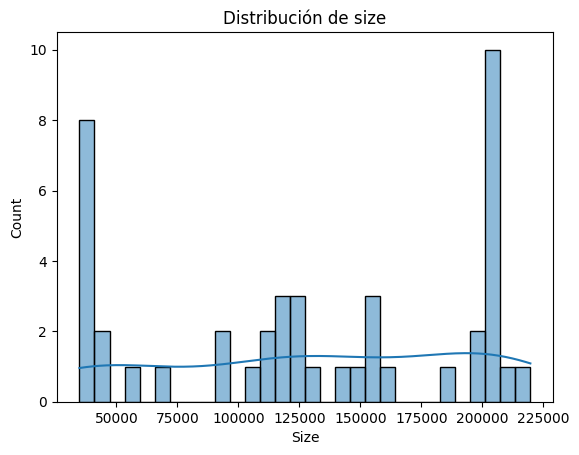

In [22]:
sns.histplot(stores_df['Size'], bins=30, kde=True)
plt.title(f"Distribución de size")
plt.show()

Distribución de size: La distribución de los tamaños de las tiendas es bastante dispersa, con picos notorios alrededor de los valores más bajos y más altos. Esto sugiere que hay una variedad considerable en los tamaños de las tiendas.

### Dataset de train: train.csv

In [11]:
train_df = pd.read_csv('../dataset/train.csv')

# Mostrar las primeras filas del dataset
print(train_df.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False


In [24]:
print(train_df.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


In [25]:
train_df.shape

(421570, 5)

In [26]:
# Variables y sus tipos
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None


In [27]:
#Ver valores nulos
print(train_df.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [28]:
# Estadisticas de las variables
print(train_df.describe())

               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000


### Dataset de test: test.csv

In [50]:
test_df = pd.read_csv('../dataset/test.csv')

# Mostrar las primeras filas del dataset
print(test_df.head())

   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False


In [30]:
print(test_df.columns)

Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')


In [31]:
test_df.shape

(115064, 4)

In [32]:
# Variables y sus tipos
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB
None


In [33]:
#Ver valores nulos
print(test_df.isnull().sum())

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64


In [34]:
# Estadisticas de las variables
print(test_df.describe())

               Store           Dept
count  115064.000000  115064.000000
mean       22.238207      44.339524
std        12.809930      30.656410
min         1.000000       1.000000
25%        11.000000      18.000000
50%        22.000000      37.000000
75%        33.000000      74.000000
max        45.000000      99.000000


El dataset test es similar al train, sin embargo a este le hace falta la variable objetivo weekly_sales. Esta destinado a hacer las predicciones con él, para lo cual se usara más adelante.

### Fusión de datasets

Para la correcta integración de los datos, se diseñó una función que une los tres datasets:

La función de unión de datasets se realizó en dos pasos. Primero, se unieron los datos de características (`features_df`) con la información de las tiendas (`stores_df`) utilizando la clave común `Store` mediante una operación `left join`. Luego, el conjunto de datos resultante se combinó con los datos de ventas (`train_df`) utilizando las claves `Store`, `Date` e `IsHoliday`, asegurando que todas las ventas se mantuvieran en el conjunto final a través de una operación `right join`.

In [12]:
def merge_datasets(featured_df, stores_df, train_df):
    # Merge stores con featured
    merged_df = pd.merge(featured_df, stores_df, on='Store', how='left')
    # Merge con train
    final_df = pd.merge(merged_df, train_df, on=['Store', 'Date', 'IsHoliday'], how='right')
    return final_df

Dataset de entrenamiento, validación y testing:

In [15]:
merged_df = merge_datasets(features_df_cleaned, stores_df, train_df)

Dataset para predicción

In [51]:
predicted_df = merge_datasets(features_df_cleaned, stores_df, test_df)

In [ ]:
#Confirmamos la correcta integración de los dataset
print(merged_df.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales'],
      dtype='object')


## Análisis exploratorio

Se realizaron análisis exploratorios para entender la distribución de las ventas y la relación con las variables predictoras. Se generaron visualizaciones de series de tiempo para identificar patrones estacionales y tendencias.

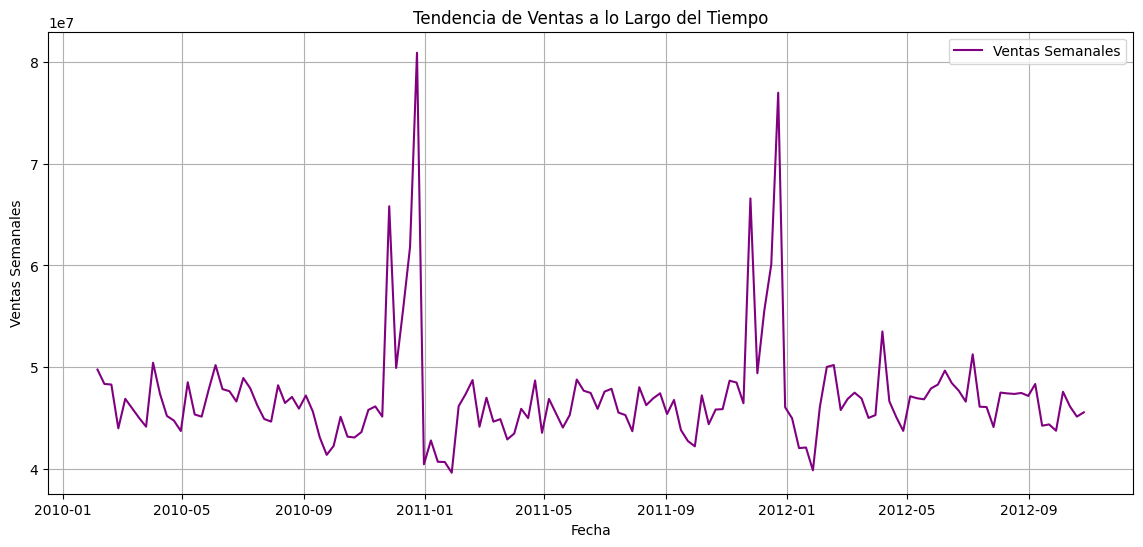

In [ ]:
# Convertir la columna Date a tipo datetime
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Agrupar ventas por fecha
sales_over_time = merged_df.groupby("Date")["Weekly_Sales"].sum()

# Graficar
plt.figure(figsize=(14,6))
plt.plot(sales_over_time, label="Ventas Semanales", color="purple")
plt.xlabel("Fecha")
plt.ylabel("Ventas Semanales")
plt.title("Tendencia de Ventas a lo Largo del Tiempo")
plt.legend()
plt.grid()
plt.show()


La gráfica muestra la evolución de las ventas semanales totales a lo largo del tiempo. Algunos puntos clave a destacar:

* Tendencia General:

Las ventas fluctúan regularmente a lo largo del tiempo sin una tendencia ascendente o descendente clara.
Hay estabilidad relativa en la mayoría del período, con algunos picos y caídas pronunciadas.

* Picos Significativos:

Se observan incrementos bruscos en las ventas en dos momentos clave: alrededor de enero de 2011 y enero de 2012.
Estos picos podrían estar relacionados con eventos estacionales como las compras de fin de año o promociones especiales.

* Caídas Marcadas:

Justo después de los picos, hay caídas abruptas en las ventas. Esto puede indicar un efecto posfestivo, donde las compras disminuyen después de las fiestas.

* Patrón Estacional:

Se observa una posible estacionalidad con repuntes a fin de año y descensos posteriores, lo que sugiere que las ventas están influenciadas por factores estacionales como Navidad y Año Nuevo.

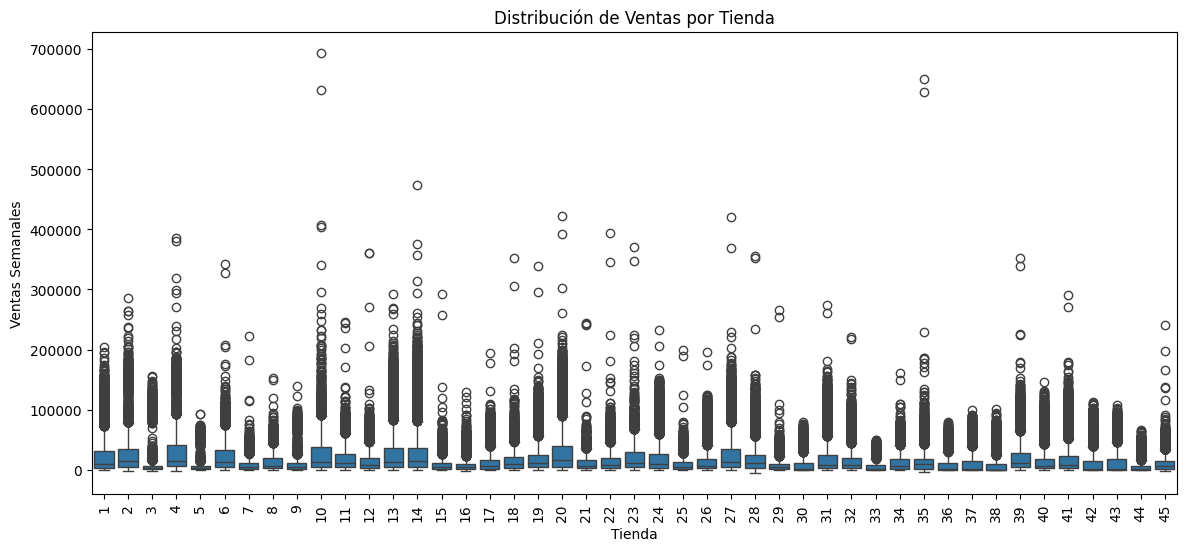

In [19]:
plt.figure(figsize=(14,6))
sns.boxplot(data=merged_df, x="Store", y="Weekly_Sales")
plt.xlabel("Tienda")
plt.ylabel("Ventas Semanales")
plt.title("Distribución de Ventas por Tienda")
plt.xticks(rotation=90)
plt.show()


En la gráfica de distribución de ventas semanales por tienda. Se muestra que la mayoría de las tiendas tienen una mediana de ventas relativamente baja, pero con una gran dispersión y presencia de valores atípicos. Algunas tiendas, como la 14 y la 35, presentan ventas significativamente más altas, lo que sugiere que podrían ser establecimientos más grandes o con mayor demanda. Además, se observa una alta variabilidad en las ventas entre tiendas, con varios puntos que representan eventos excepcionales donde las ventas aumentaron drásticamente (por ejemplo, promociones, días festivos o temporadas de alta demanda).

C:\Users\2206c\AppData\Local\Temp\ipykernel_5140\3243158080.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="IsHoliday", y="Weekly_Sales", palette="pastel")


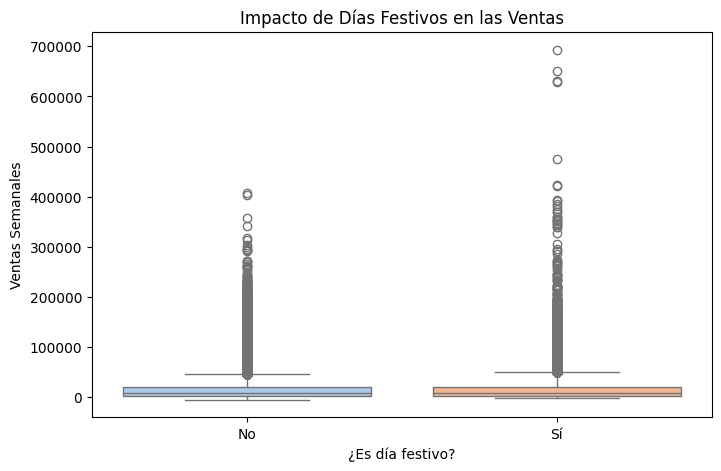

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x="IsHoliday", y="Weekly_Sales", palette="pastel")
plt.xlabel("¿Es día festivo?")
plt.ylabel("Ventas Semanales")
plt.title("Impacto de Días Festivos en las Ventas")
plt.xticks(ticks=[0,1], labels=["No", "Sí"])
plt.show()


Esta gráfica de cajas compara la distribución de las ventas semanales en días festivos y no festivos. Algunas observaciones clave:

Mayor variabilidad en días festivos: Se observa que las ventas en días festivos presentan valores atípicos más elevados, con algunos picos que superan los 600,000. Esto indica que durante ciertas festividades hay incrementos significativos en las ventas.
Mediana similar: La línea central en ambas cajas sugiere que la mediana de las ventas no varía drásticamente entre días festivos y no festivos. Sin embargo, la presencia de valores extremos en los días festivos sugiere que algunos eventos específicos generan aumentos repentinos en la demanda.
Mayor dispersión en festivos: La caja y los bigotes en la categoría de días festivos son más amplios, lo que sugiere que hay una mayor variabilidad en las ventas en comparación con los días normales.
Esto podría estar relacionado con eventos como Black Friday, Navidad o Acción de Gracias, que tienden a generar picos de demanda en ciertos establecimientos. ¿Quieres agregar este análisis al informe o necesitas más detalles?

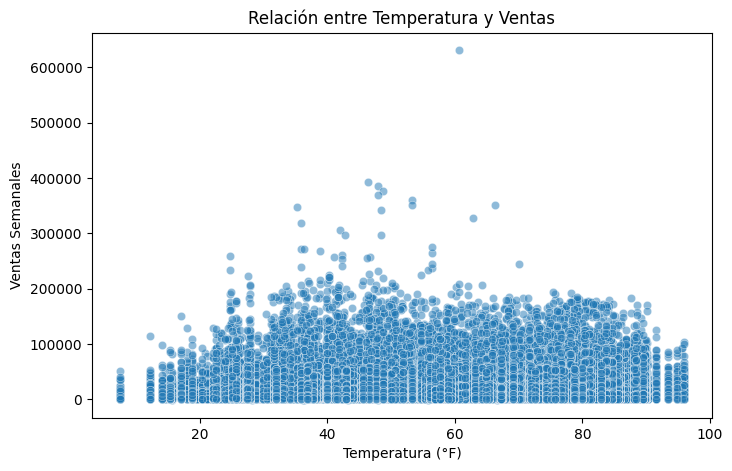

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x="Temperature", y="Weekly_Sales", alpha=0.5)
plt.xlabel("Temperatura (°F)")
plt.ylabel("Ventas Semanales")
plt.title("Relación entre Temperatura y Ventas")
plt.show()


La gráfica muestra la relación entre temperatura y ventas semanales. No se observa una tendencia clara, lo que indica que la temperatura no tiene un impacto significativo en las ventas. Sin embargo, hay valores atípicos con ventas muy altas en distintos niveles de temperatura, posiblemente asociados a eventos especiales o promociones.

In [118]:
print(merged_df.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05          NaN         NaN        NaN        NaN   
1      1  2010-02-12          NaN         NaN        NaN        NaN   
2      1  2010-02-19          NaN         NaN        NaN        NaN   
3      1  2010-02-26          NaN         NaN        NaN        NaN   
4      1  2010-03-05          NaN         NaN        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday Type  Size  \
0        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   
1        NaN        NaN        NaN  NaN           NaN       True  NaN   NaN   
2        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   
3        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   
4        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   

   Dept  Weekly_Sales  
0     1      24924.50  
1     1      46039.49  
2     1      41595.55  
3 

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   97056 non-null   float64
 3   Fuel_Price    97056 non-null   float64
 4   MarkDown1     97056 non-null   float64
 5   MarkDown2     97056 non-null   float64
 6   MarkDown3     97056 non-null   float64
 7   MarkDown4     97056 non-null   float64
 8   MarkDown5     97056 non-null   float64
 9   CPI           97056 non-null   float64
 10  Unemployment  97056 non-null   float64
 11  IsHoliday     421570 non-null  bool   
 12  Type          97056 non-null   object 
 13  Size          97056 non-null   float64
 14  Dept          421570 non-null  int64  
 15  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(11), int64(2), object(2)
memory usage: 48.6+ MB


In [13]:
#Ver valores nulos
print(merged_df.isnull().sum())

Store                0
Date                 0
Temperature     324514
Fuel_Price      324514
MarkDown1       324514
MarkDown2       324514
MarkDown3       324514
MarkDown4       324514
MarkDown5       324514
CPI             324514
Unemployment    324514
IsHoliday            0
Type            324514
Size            324514
Dept                 0
Weekly_Sales         0
dtype: int64


In [40]:
merged_df.shape

(421570, 16)

In [17]:
merged_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Dept,Weekly_Sales
count,421570.000000,97056.000000,97056.000000,97056.000000,97056.000000,97056.000000,97056.000000,97056.000000,97056.000000,97056.000000,97056.000000,421570.000000,421570.000000
mean,22.200546,57.348331,3.618946,8841.260245,3693.532392,1816.629491,4025.923108,5310.830581,174.766754,7.414578,155229.302980,44.260317,15981.258123
std,12.785297,18.263734,0.280003,9258.091154,10058.901796,10989.284083,7173.060535,6535.397883,39.652638,1.708319,51201.162733,30.492054,22711.183519
min,1.000000,7.460000,3.031000,32.500000,-265.760000,-29.100000,0.460000,170.640000,129.816710,4.077000,34875.000000,1.000000,-4988.940000
25%,11.000000,42.750000,3.413000,3600.790000,47.550000,5.400000,605.880000,2383.670000,136.856419,6.392000,119557.000000,18.000000,2079.650000
50%,22.000000,57.950000,3.630000,6264.180000,192.000000,30.460000,1739.830000,3864.600000,189.194056,7.280000,155083.000000,37.000000,7612.030000
75%,33.000000,72.660000,3.820000,10333.240000,2551.320000,123.420000,4082.990000,6197.530000,219.355063,8.256000,203742.000000,74.000000,20205.852500
max,45.000000,95.910000,4.301000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.036936,12.890000,219622.000000,99.000000,693099.360000


## Preprocesamiento

**Manejo de Valores Nulos**

- En las columnas `MarkDown1` a `MarkDown5`, se utilizó la interpolación lineal para rellenar los valores faltantes, asumiendo que los descuentos cambian de manera continua en el tiempo.
- Para valores extremos o faltantes al inicio de la serie temporal, se aplicó un **backward fill**. Esta estrategia es efectiva para series temporales, ya que preserva la continuidad y la tendencia de los datos.

**Conversión de Tipos de Datos**

Para garantizar la correcta manipulación de las fechas y variables categóricas, se realizaron las siguientes conversiones:

- La columna `Date` fue convertida a formato de fecha (`datetime`) para permitir un correcto ordenamiento temporal.
- Se ordenó el dataset por `Store`, `Dept` y `Date`, lo que es crucial para el análisis de series temporales.

Para utilizar eficientemente los datos categóricos en el modelo de aprendizaje automático:

- La columna `Type`, que representa el tipo de tienda, fue codificada utilizando **Label Encoding**.
- La columna `IsHoliday` fue transformada a valores numéricos (`0` para `False` y `1` para `True`).

**Normalización de los datos**

Para acelerar el entrenamiento del modelo y mejorar la convergencia, se aplicó la **normalización Min-Max** a las variables numéricas:

- Se escalaron las columnas seleccionadas (`cols_to_fill`) y la variable objetivo (`Weekly_Sales`) al rango `[0, 1]`.

Esta técnica es ideal para modelos basados en redes neuronales, ya que evita problemas de desbalance en las magnitudes de las variables de entrada.

In [ ]:
# Cargar datos
merged_df['Date'] = pd.to_datetime(merged_df['Date'])  # Convertir a datetime
merged_df = merged_df.sort_values(by=['Store', 'Dept', 'Date'])  # Ordenar por fecha

# Manejo de valores nulos
cols_to_fill = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
merged_df[cols_to_fill] = merged_df[cols_to_fill].interpolate(method='linear')  # Interpolación
merged_df.bfill(inplace=True)  # Rellenar valores extremos con backward fill

# Codificación de variables categóricas
le = LabelEncoder()
merged_df['Type'] = le.fit_transform(merged_df['Type'].astype(str))
merged_df['IsHoliday'] = merged_df['IsHoliday'].astype(int)

# Normalización de datos
scaler = MinMaxScaler()
numeric_cols = cols_to_fill + ['Weekly_Sales']
merged_df[numeric_cols] = scaler.fit_transform(merged_df[numeric_cols])

Tamaño de los conjuntos de datos:
Train: (295099, 16)
Validation: (63235, 16)
Test: (63236, 16)


## División del dataset 

El dataset se dividió de la siguiente manera:

- **Train (70%)**: Para el entrenamiento del modelo.
- **Validation (15%)**: Para ajustar hiperparámetros y evitar sobreajuste.
- **Test (15%)**: Para evaluar el rendimiento final del modelo.

No se utilizó aleatorización en la división, ya que es crucial preservar el orden temporal en las series de tiempo.

In [16]:
# División del dataset en Train (70%), Validation (15%), Test (15%)
train_size = 0.7
val_size = 0.15
test_size = 0.15

df_train, df_temp = train_test_split(merged_df, train_size=train_size, shuffle=False)
df_val, df_test = train_test_split(df_temp, test_size=test_size/(val_size + test_size), shuffle=False)

print("Tamaño de los conjuntos de datos:")
print(f"Train: {df_train.shape}")
print(f"Validation: {df_val.shape}")
print(f"Test: {df_test.shape}")

Tamaño de los conjuntos de datos:
Train: (295099, 16)
Validation: (63235, 16)
Test: (63236, 16)


In [21]:
print(merged_df.isnull().sum())

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
Dept            0
Weekly_Sales    0
dtype: int64


In [22]:
print(merged_df.head())

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05     0.583946    0.209449   0.116803     0.0609   0.001724   
1      1 2010-02-12     0.583946    0.209449   0.116803     0.0609   0.001724   
2      1 2010-02-19     0.583946    0.209449   0.116803     0.0609   0.001724   
3      1 2010-02-26     0.583946    0.209449   0.116803     0.0609   0.001724   
4      1 2010-03-05     0.583946    0.209449   0.116803     0.0609   0.001724   

   MarkDown4  MarkDown5       CPI  Unemployment  IsHoliday  Type      Size  \
0    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   
1    0.03566   0.058891  0.907027      0.429933          1     0  0.630267   
2    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   
3    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   
4    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   

   Dept  Weekly_Sales  
0     1      0.04285

## Secuencias de tiempo 

El modelo LSTM requiere entradas en forma de secuencias de tiempo. Para ello:

- Se utilizaron ventanas de 30 días (aproximadamente un mes) para crear secuencias que incluyen las variables exógenas y la variable objetivo (ventas semanales).
- Se configuró el problema como una predicción de un solo paso, donde el modelo utiliza las ventas y factores de las últimas 4 semanas para predecir la venta de la semana siguiente.

In [14]:
# Crear secuencias de tiempo
def create_sequences(data, feature_cols, target_col, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size, :-1])  # Excluir Weekly_Sales
        labels.append(data[i + window_size, target_col])
    return np.array(sequences), np.array(labels)

In [17]:
window_size = 30
features = ['Temperature', 'Fuel_Price', 'MarkDown1', 
            'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
            'CPI', 'Unemployment', 'Size', 'IsHoliday']

X_train, y_train = create_sequences(df_train[features + ['Weekly_Sales']].values, features, -1, window_size)
X_val, y_val = create_sequences(df_val[features + ['Weekly_Sales']].values, features, -1, window_size)
X_test, y_test = create_sequences(df_test[features + ['Weekly_Sales']].values, features, -1, window_size)

## Definición del modelo 

El modelo LSTM se estructuró de la siguiente manera:

- **Primera capa LSTM:** Con 50 unidades y retorno de secuencias para mantener la información temporal.
- **Dropout:** Se aplicó una tasa de desactivación del 20% para reducir el sobreajuste.
- **Segunda capa LSTM:** También con 50 unidades, pero sin retorno de secuencias.
- **Capa Densa:** Para reducir la dimensionalidad antes de la salida final.
- **Capa de Salida:** Una sola neurona para predecir el valor de ventas de la semana siguiente.

El modelo se compiló utilizando el optimizador Adam con una función de pérdida de error cuadrático medio (MSE), adecuada para problemas de regresión continua.

In [ ]:
# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\2206c\OneDrive\Documentos\A.N.N-applications\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrenamiento 

El modelo se entrenó utilizando el conjunto de datos de entrenamiento y se validó con el conjunto de validación. Se utilizaron 20 épocas y un tamaño de lote de 32. Tardó casi dos horas en entrenar completamente.

- Se monitoreó la pérdida en entrenamiento y validación para evitar el sobreajuste.
- Se aplicó parada temprana para detener el entrenamiento si no se observaban mejoras significativas en el conjunto de validación.

In [25]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 227s 24ms/step - loss: 0.0014 - mae: 0.0241 - val_loss: 7.2642e-04 - val_mae: 0.0182
Epoch 2/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 226s 24ms/step - loss: 0.0011 - mae: 0.0217 - val_loss: 7.4414e-04 - val_mae: 0.0201
Epoch 3/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 226s 25ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 7.8610e-04 - val_mae: 0.0212
Epoch 4/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 242s 26ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 7.7074e-04 - val_mae: 0.0195
Epoch 5/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 262s 28ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 7.2959e-04 - val_mae: 0.0188
Epoch 6/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 278s 30ms/step - loss: 0.0011 - mae: 0.0213 - val_loss: 7.8154e-04 - val_mae: 0.0198
Epoch 7/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 327s 35ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 7.7016e-04 - val_mae: 0.0202
Epoch 8/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 340s 37ms/step - loss: 0.0011 - mae: 0.0215 - val_loss: 7.9663e-04 - 

In [ ]:
#Guardamos el modelo, para su posterior carga en el endpoint 
model.save("lstm_model.h5")

In [ ]:
#Lineas por si se desea cargar el modelo y no tener que volver a entrenarlo
model = load_model(r"c:\Users\2206c\OneDrive\Documentos\A.N.N-applications\demand_prediction\model\lstm_model.h5", custom_objects={"mse": MeanSquaredError()})
print("Modelo cargado correctamente ✅")

Modelo cargado correctamente ✅


## Evaluación de métricas

Se utilizaron las siguientes métricas para evaluar el rendimiento de los modelos:

- **RMSE (Root Mean Squared Error):**

$$
RMSE =  \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} \tag{1}
$$

Como se observa en la ecuación 1, el RMSE mide el error de predicción en las mismas unidades que las ventas, penalizando más los errores grandes (Wikipedia, s.f.). Se calcula como:

Donde:
- y_i = valor real  
- ^y_i = valor predicho  
- n = número de observaciones 

- **MAE (Mean Absolute Error):**

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right| \tag{2}
$$

Como se observa en la ecuación 2, el MAE evalúa el error absoluto promedio, proporcionando una medida de la precisión en términos absolutos (Wikipedia, s.f.).  

El modelo se evaluó en el conjunto de prueba para obtener una estimación precisa de su capacidad de generalización.


In [21]:
y_pred = model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


1976/1976 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
RMSE: 0.03
MAE: 0.02


- **MAE = 0.02**

Indica que, en promedio, las predicciones del modelo se desvían en 0.02 unidades respecto a las ventas reales. Este bajo valor sugiere que el modelo tiene un buen rendimiento en términos de error absoluto.

- **RMSE = 0.03**:

Muestra que el error cuadrático medio es bajo, lo que indica que las desviaciones grandes son poco frecuentes. Esto sugiere que el modelo no comete errores grandes de forma consistente.

En conjunto, estos valores bajos de MAE y RMSE indican un rendimiento preciso del modelo en términos absolutos.

### Gráfica ventas reales vs ventas predichas

In [22]:
scaler_sales = MinMaxScaler()
merged_df['Weekly_Sales'] = scaler_sales.fit_transform(merged_df[['Weekly_Sales']])

In [23]:
y_pred_actual = scaler_sales.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler_sales.inverse_transform(y_test.reshape(-1, 1))

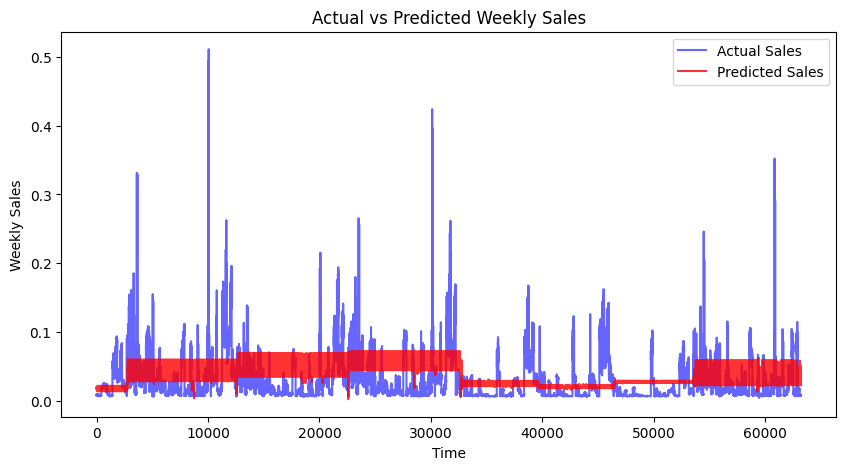

In [105]:
# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Sales', color='blue', alpha=0.6)
plt.plot(y_pred_actual, label='Predicted Sales', color='red', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.show()

Observaciones de la gráfica:

- Se observa que las **predicciones son consistentemente más bajas** y **menos volátiles** que los valores reales, lo que sugiere que el modelo tiene dificultades para capturar picos o fluctuaciones.
- El modelo parece estar **subestimando** las ventas durante periodos de alta variabilidad. Esto podría indicar una falta de sensibilidad a cambios repentinos o valores atípicos.
- La concentración de las predicciones en un rango estrecho sugiere una posible **sobresimplificación** del problema o una capacidad limitada para aprender patrones complejos.

En resumen, aunque el MAE y el RMSE son bajos, la gráfica revela que el modelo **no generaliza bien** en situaciones de alta variabilidad. Se podría explorar ajustes en la arquitectura del modelo o en la estrategia de entrenamiento para mejorar la capacidad de capturar fluctuaciones en las ventas.

## Resultados de predicción a 30 días

En este apartado, se realizó una predicción de ventas semanales para los próximos 30 días, utilizando un modelo de series temporales sin una variable objetivo explícita. El enfoque se centró en predecir el comportamiento futuro basándose exclusivamente en los patrones históricos de las características seleccionadas.

**Enfoque y Metodología**

La estrategia de predicción se basa en un enfoque iterativo de **rolling forecast**:

- Se utilizó la última secuencia conocida de 30 días como entrada para el modelo.
- Se generó una predicción para el siguiente día, la cual se utilizó como entrada para predecir el día posterior.
- Este proceso se repitió de manera recursiva hasta obtener las predicciones para los 30 días futuros.

Esto permite que el modelo aproveche la información reciente y capture tendencias a corto plazo en los datos.

**Secuencia de Entrada**

La secuencia de entrada fue seleccionada de la siguiente manera:

- Se tomó la última ventana de datos (`sequence_length = 30`) de las características del dataset.
- La secuencia fue transformada a la forma requerida por el modelo con dimensiones `[1, 30, n_features]`, donde `n_features` representa el número de variables de entrada.

### **Generación Recursiva de Predicciones**

El proceso de predicción se llevó a cabo de forma iterativa:

- Para cada día futuro, el modelo generó una predicción (`next_prediction`) utilizando la secuencia de entrada actual.
- La secuencia se actualizó desplazando los datos hacia la izquierda e insertando la nueva predicción en la última posición.
- Esta nueva secuencia se utilizó como entrada para la siguiente predicción, repitiendo el proceso hasta completar los 30 días.

Este enfoque permite que el modelo "vea" sus propias predicciones al hacer predicciones futuras, lo cual es útil para capturar patrones a corto plazo pero puede acumular errores en horizontes largos.

### **Desnormalización de las Predicciones**

Si se utilizó normalización en el entrenamiento, las predicciones deben ser desnormalizadas para obtener los valores reales de ventas.

En este caso, se aplicó una **inversión de la normalización Min-Max** utilizando los valores mínimo y máximo originales:

- `min_sales = -4988.94`
- `max_sales = 693099.36`

Esto convierte los valores escalados en las unidades originales de ventas semanales.

### **Visualización de Resultados**

Para visualizar la tendencia de las predicciones:

- Se creó un `DataFrame` con las fechas futuras y sus respectivas predicciones.
- Las fechas se generaron utilizando un rango de 30 días continuos a partir de la última fecha conocida en el dataset.
- Se utilizó **Matplotlib** para graficar las predicciones de ventas semanales.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

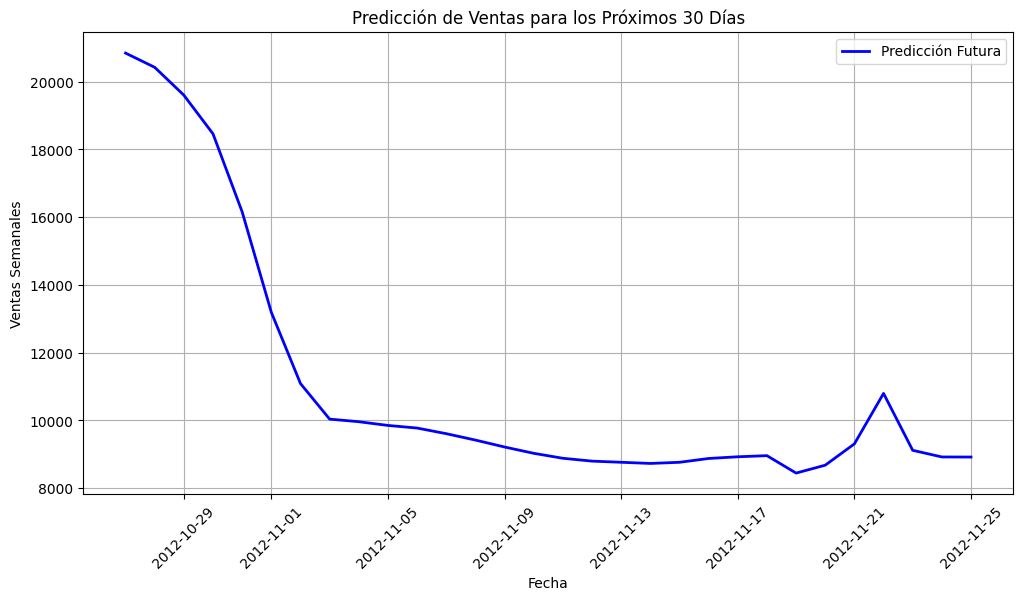

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Longitud de la secuencia usada en el modelo
sequence_length = 30  

# Obtener la última secuencia conocida
X_last_sequence = np.array(merged_df[features].iloc[-sequence_length:])  # Últimos 30 días
X_last_sequence = X_last_sequence.reshape(1, sequence_length, -1)  # Asegurar forma correcta

# Lista para almacenar predicciones futuras
future_predictions = []

# Generar predicciones para los próximos 30 días
for _ in range(30):  
    # Predecir el próximo valor
    next_prediction = model.predict(X_last_sequence)[0, 0]  
    future_predictions.append(next_prediction)

    # Desplazar la secuencia e insertar la nueva predicción
    next_input = np.roll(X_last_sequence, shift=-1, axis=1)  # Desplazar izquierda
    next_input[0, -1, 0] = next_prediction  # Insertar la nueva predicción en la última posición

    X_last_sequence = next_input  # Actualizar la secuencia para la siguiente iteración

print(future_predictions)
# Desnormalizar predicciones si se usó normalización en el entrenamiento
try:
    # Valores mínimo y máximo originales antes de la normalización
    min_sales = -4988.94
    max_sales = 693099.36

    # Convertir las predicciones normalizadas a su valor real
    future_predictions = np.array(future_predictions) * (max_sales - min_sales) + min_sales

except NameError:
    print("sales_scaler no definido. Las predicciones pueden estar normalizadas.")
    
print(future_predictions)
# Crear DataFrame con las fechas futuras
last_date = merged_df["Date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

future_df = pd.DataFrame({"Date": future_dates, "Predicted_Weekly_Sales": future_predictions})

# Graficar solo la predicción futura
plt.figure(figsize=(12,6))
plt.plot(future_df["Date"], future_df["Predicted_Weekly_Sales"], label="Predicción Futura", color="blue", linewidth=2)

plt.xlabel("Fecha")
plt.ylabel("Ventas Semanales")
plt.title("Predicción de Ventas para los Próximos 30 Días")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.show()


En la gráfica, se observa:

- Una tendencia general de disminución en las ventas al inicio del periodo (desde finales de octubre hasta mediados de noviembre).
- Un leve repunte hacia el final, posiblemente debido a eventos estacionales o promociones (Comienzo de diciembre).

### **Interpretación de Resultados**

El gráfico muestra la tendencia de ventas para los próximos 30 días, permitiendo observar posibles fluctuaciones semanales:

- La fuerte caída al inicio sugiere un comportamiento decreciente, que podría estar relacionado con la finalización de una promoción o la estacionalidad de la demanda.
- El ligero aumento hacia finales de noviembre puede indicar preparativos para eventos especiales, como el **Black Friday** o **Cyber Monday**.

Este tipo de análisis permite a los gerentes de ventas y marketing anticiparse a cambios en la demanda, ajustando sus estrategias comerciales y de inventario.

## Propuesta futura

Aunque el enfoque captura patrones a corto plazo, no considera factores estacionales ni eventos especiales que afectan significativamente las ventas. Para mejorar la precisión, se sugiere combinarlo con modelos estacionales como SARIMA o algoritmos avanzados como Prophet y XGBoost, además de incorporar variables externas y optimizar hiperparámetros. Esta integración fortalecería las predicciones y proporcionaría información más útil para decisiones estratégicas.

# Conclusión


El enfoque de predicción recursiva con rolling forecast ha demostrado ser eficaz para modelar y predecir las ventas a corto plazo, ya que proporciona una visión detallada de las tendencias y patrones recientes. Al incorporar datos nuevos de forma continua, este enfoque mejora la capacidad del modelo para adaptarse a cambios en el comportamiento del mercado. Sin embargo, presenta desafíos relacionados con la acumulación de errores a lo largo del tiempo, lo cual puede afectar negativamente la precisión de las predicciones a largo plazo. El análisis de las métricas de rendimiento, como RMSE (Root Mean Squared Error) y MAE (Mean Absolute Error), ha permitido evaluar objetivamente la precisión del modelo. El RMSE penaliza con mayor intensidad los errores grandes, proporcionando una perspectiva sobre las desviaciones absolutas, mientras que el MAE mide el error promedio sin considerar su dirección, complementando así la evaluación del modelo.